<a href="https://colab.research.google.com/github/Finyasy/Image_classify/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import numpy as np

In [25]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('user-agent','Mozilla/5.0')] 
urllib.request.install_opener(opener)

In [26]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data',train=True,download=True,transform=transform)
test_data = datasets.MNIST(root='data',train=True,download=False,transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

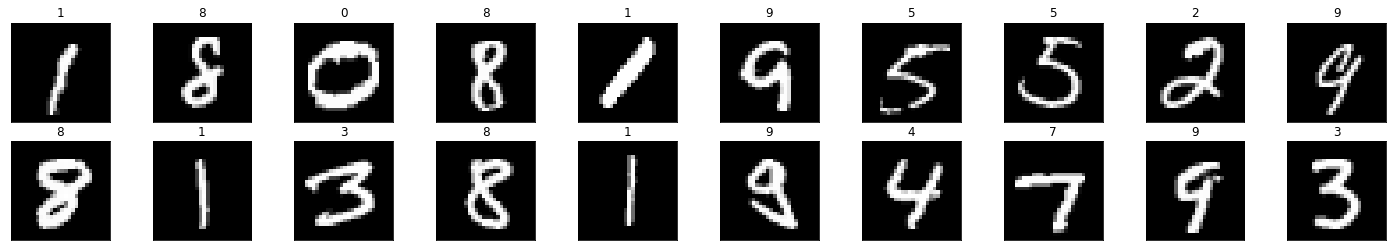

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images,labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(images[idx]),cmap='gray')

  ax.set_title(str(labels[idx].item()))

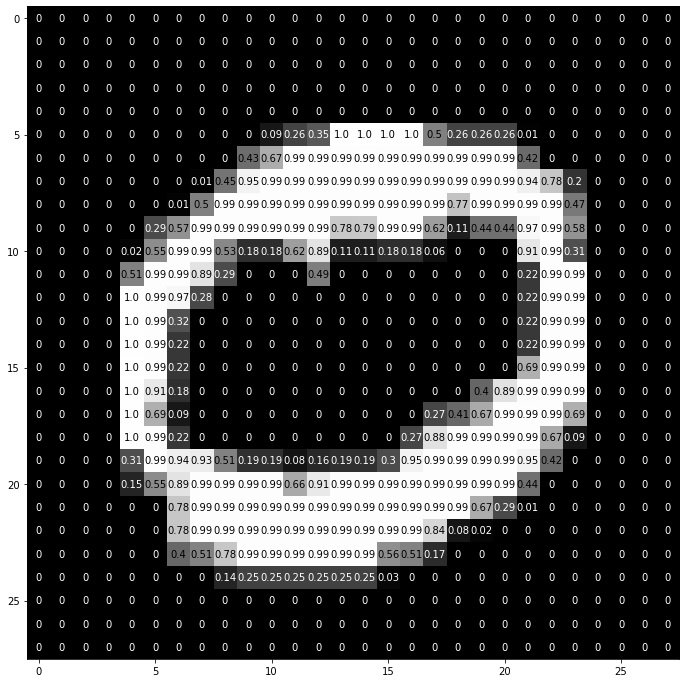

In [28]:
img = np.squeeze(images[2])

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')
width,height = img.shape
thresh = img.max()/2.5
for x in range(width):
  for y in range(height):
    val = round(img[x][y],2) if img[x][y] !=0 else 0
    ax.annotate(str(val),xy=(y,x),
                horizontalalignment='center',
                verticalalignment='center',
                color='white' if img[x][y]<thresh else 'black')


In [29]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    hidden_1 = 512
    hidden_2 = 512

    self.fc1 = nn.Linear(28*28,hidden_1)
    self.fc2 = nn.Linear(hidden_1,hidden_2)
    self.fc3 = nn.Linear(hidden_2,10)
    self.dropout = nn.Dropout(0.2)

  def forward(self,x):
    x = x.view(-1,28*28)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

model = Net()
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

In [32]:
# number of epochs to train the model
n_epochs = 10

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
  train_loss = 0.0
  valid_loss = 0.0

      ###################
    # train the model #
    ###################
  model.train()
  for data,target in train_loader:
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    ######################    
    # validate the model #
    ######################
  model.eval()
  for data,target in valid_loader:
    output = model(data)
    loss = criterion(output,target)
    valid_loss += loss.item()

  # print training/validation statistics 
  # calculate average loss over an epoch
  train_loss = train_loss / len(train_loader.dataset)
  valid_loss = valid_loss / len(valid_loader.dataset)


  print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))
  
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.014322
Validation loss decreased (inf --> 0.002863).  Saving model ...
Epoch: 2 	Training Loss: 0.011359
Validation loss decreased (0.002863 --> 0.002362).  Saving model ...
Epoch: 3 	Training Loss: 0.009433
Validation loss decreased (0.002362 --> 0.002003).  Saving model ...
Epoch: 4 	Training Loss: 0.007968
Validation loss decreased (0.002003 --> 0.001736).  Saving model ...
Epoch: 5 	Training Loss: 0.006975
Validation loss decreased (0.001736 --> 0.001539).  Saving model ...
Epoch: 6 	Training Loss: 0.006080
Validation loss decreased (0.001539 --> 0.001413).  Saving model ...
Epoch: 7 	Training Loss: 0.005528
Validation loss decreased (0.001413 --> 0.001306).  Saving model ...
Epoch: 8 	Training Loss: 0.004875
Validation loss decreased (0.001306 --> 0.001182).  Saving model ...
Epoch: 9 	Training Loss: 0.004431
Validation loss decreased (0.001182 --> 0.001131).  Saving model ...
Epoch: 10 	Training Loss: 0.004067
Validation loss decreased (0.001131 --> 0.0

In [33]:
#Load the Model with the Lowest Validation Loss

model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [34]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data,target in test_loader:
  output = model(data)
  loss = criterion(output,target)
  test_loss += loss.item()*data.size(0)
  _,pred = torch.max(output,1)
  correct = np.squeeze(pred.eq(target.data.view_as(pred)))

  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.083743

Test Accuracy of     0: 98% (5855/5923)
Test Accuracy of     1: 98% (6634/6742)
Test Accuracy of     2: 96% (5776/5958)
Test Accuracy of     3: 95% (5872/6131)
Test Accuracy of     4: 97% (5710/5842)
Test Accuracy of     5: 97% (5297/5421)
Test Accuracy of     6: 98% (5839/5918)
Test Accuracy of     7: 97% (6124/6265)
Test Accuracy of     8: 97% (5694/5851)
Test Accuracy of     9: 96% (5749/5949)

Test Accuracy (Overall): 97% (58550/60000)


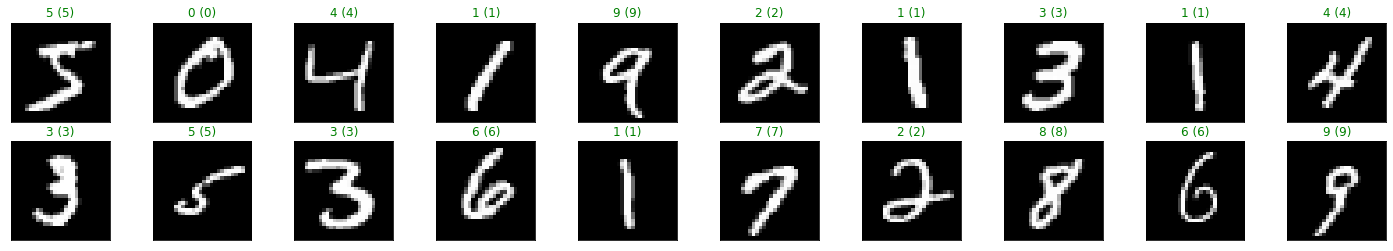

In [35]:
dataiter = iter(test_loader)
images,labels = dataiter.next()

output = model(images)

_,preds = torch.max(output,1)

images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(images[idx]),cmap='gray')
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))